Disciplina: Aprendizagem de Máquina

Período: 2025.1

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 2 - Regressão linear, polinomial e regularização

## Questão 1

### Considere o conjunto de dados disponível em breastcancer.csv, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset.

a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

- Regressão logística (treinado com GD ou SGD);
- Análise do discriminante Gaussiano;
- Naive Bayes Gaussiano.

b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

In [50]:
# A biblioteca numpy nos ajuda a trabalhar com arrays e fazer cálculos numéricos com eficiência.
import numpy as np

# Carregando os dados
data = np.genfromtxt('breastcancer.csv', delimiter=',')

# X recebe todas as colunas menos a última, ou seja, os 30 atributos.
X = data[:, :-1]

# y recebe apenas a última coluna, que representa o rótulo (classe): 0 ou 1
y = data[:, -1]

# 2. Normalizando os atributos (z-score)
# Padroniza os dados de X, transformando cada atributo para ter: Média 0 e Desvio padrão 1
# Isso melhora a performance do gradiente descendente (evita que atributos com escala maior dominem o treinamento).
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# 3. Função sigmoide
# Função usada para transformar qualquer valor real em um número entre 0 e 1 (probabilidade).
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 4. Função de custo (log-loss)
# Calcula o erro médio da Regressão Logística.
def compute_loss(y_true, y_pred):
    eps = 1e-15  # para evitar log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps) #np.clip impede que log(0) ocorra (o que geraria erro de cálculo).
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# 5. Treinamento com Gradiente (GD)
def train_logistic_regression(X, y, lr=0.1, epochs=1000):  # lr: taxa de aprendizado (quanto ajusta por vez).

    m, n = X.shape     # m = número de amostras; n = número de atributos
    w_gd = np.zeros(n)    # w é o vetor de pesos (inicializa pesos com zeros)
    b_gd = 0              # b é o viés/bias (inicializa o viés com 0)
    losses_gd = []        # para guardar o custo a cada época


    # Para cada época (iterando epochs vezes), calcula:
    for _ in range(epochs):
        z = np.dot(X, w_gd) + b_gd   # combinação linear dos atributos.
        y_pred = sigmoid(z)    # aplica a função sigmoide para obter probabilidades de classe 1.

        # Gradientes (derivadas do custo em relação aos parâmetros):
        dw = np.dot(X.T, (y_pred - y)) / m     # gradiente em relação aos pesos.
        db = np.mean(y_pred - y)               # gradiente em relação ao viés.

        # Atualização dos pesos e viés com gradiente descendente.
        w_gd -= lr * dw
        b_gd -= lr * db

        # Calcula o custo da época atual e salva no array losses
        loss = compute_loss(y, y_pred)
        losses_gd.append(loss)

    # Retorna os pesos, o viés e a lista de perdas.
    return w_gd, b_gd, losses_gd

# 6. Stochastic Gradient Descent (SGD)
def train_logistic_regression_sgd(X, y, lr=0.01, epochs=100):

    m, n = X.shape
    w_sgd = np.zeros(n)
    b_sgd = 0
    losses_sgd = []

    for epoch in range(epochs):
      total_loss = 0

      for i in range(m):
        xi = X[i]
        yi = y[i]

        z = np.dot(xi, w_sgd) + b_sgd
        y_pred = sigmoid(z)

        error = y_pred - yi

        dw = xi * error
        db = error

        # Atualizações do SGD (por amostra)
        w_sgd -= lr * dw
        b_sgd -= lr * db

        # Acumula o erro da amostra
        total_loss += compute_loss(np.array([yi]), np.array([y_pred]))

      # Guarda a perda média da época
      losses_sgd.append(total_loss / m)

    return w_sgd, b_sgd, losses_sgd

# 7. GDA: Gaussian Discriminant Analysis

def train_gda(X, y):
    m, n = X.shape

    # φ: proporção de amostras da classe 1
    phi = np.mean(y)

    # Médias por classe
    mu0 = np.mean(X[y == 0], axis=0)
    mu1 = np.mean(X[y == 1], axis=0)

    # Matriz de covariância compartilhada
    sigma = np.zeros((n, n))

    for i in range(m):
        xi = X[i].reshape(-1, 1)
        mu = mu1 if y[i] == 1 else mu0
        mu = mu.reshape(-1, 1)
        sigma += (xi - mu) @ (xi - mu).T

    sigma /= m
    sigma_inv = np.linalg.inv(sigma)

    # Parâmetros da fronteira de decisão linear
    w_gda = sigma_inv @ (mu1 - mu0)
    b_gda = -0.5 * mu1.T @ sigma_inv @ mu1 + 0.5 * mu0.T @ sigma_inv @ mu0 + np.log(phi / (1 - phi))

    return w_gda, b_gda

# 8. Naive Bayes Gaussiano
def train_gaussian_naive_bayes(X, y):

    classes = np.unique(y)
    n_features = X.shape[1]

    # Inicializa dicionários para guardar as estatísticas por classe
    class_priors = {}
    class_means = {}
    class_stds = {}

    for cls in classes:
        X_cls = X[y == cls]
        class_priors[cls] = len(X_cls) / len(X)
        class_means[cls] = np.mean(X_cls, axis=0)
        class_stds[cls] = np.std(X_cls, axis=0) + 1e-9  # para evitar divisão por zero

    return class_priors, class_means, class_stds

# 9. Previsão - Calcula a probabilidade de cada amostra pertencer à classe 1.
def predict(X, w, b):
    probs = sigmoid(np.dot(X, w) + b)

    # Converte para rótulo binário: se a probabilidade ≥ 0.5, retorna 1; senão, 0.
    return (probs >= 0.5).astype(int)

# 10. Previsão com GDA
def predict_gda(X, w, b):
    z = np.dot(X, w) + b
    return (z >= 0).astype(int)

# 11. Previsão com Naive Bayes Gaussiano
def predict_naive_bayes(X, priors, means, stds):

    predictions = []

    for x in X:
        posteriors = {}

        for cls in priors:
            # Probabilidade logarítmica para evitar underflow
            prior_log = np.log(priors[cls])
            likelihoods_log = -0.5 * np.sum(np.log(2 * np.pi * stds[cls]**2)) \
                              -0.5 * np.sum(((x - means[cls])**2) / (stds[cls]**2))
            posteriors[cls] = prior_log + likelihoods_log

        # Classe com maior probabilidade posterior
        predicted_class = max(posteriors, key=posteriors.get)
        predictions.append(predicted_class)

    return np.array(predictions, dtype=int)


# 12. Acurácia por classe - Calcula a acurácia separadamente para cada classe (classe 0 e classe 1).
def accuracy_per_class(y_true, y_pred):

    accuracies = []

    for class_value in [0, 1]:
        mask = y_true == class_value
        class_accuracy = np.mean(y_pred[mask] == y_true[mask])
        accuracies.append(class_accuracy)

    return accuracies

# 13. Validação Cruzada (K-Fold)
# Gera uma lista de índices aleatórios para embaralhar os dados.
def cross_validate_manual(X, y, k=10, use_sgd=False, use_gda=False, use_nb=False): # k=10: número de folds.

    if sum([use_sgd, use_gda, use_nb]) > 1:
      raise ValueError("Escolha apenas um dos modos: SGD, GDA ou Naive Bayes.")

    num_samples = len(X)
    indices = np.arange(num_samples)
    np.random.seed(42)
    np.random.shuffle(indices)

    # Calcula o tamanho de cada fold de forma equilibrada.
    fold_sizes = (num_samples // k) * np.ones(k, dtype=int)
    fold_sizes[:num_samples % k] += 1

    # Inicializa variáveis de controle e arrays para armazenar resultados.
    current_index = 0
    fold_accuracies = []
    fold_class_accuracies = []

    # Divide os dados em treinamento e teste para cada fold.
    for fold_size in fold_sizes:

        start, stop = current_index, current_index + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate((indices[:start], indices[stop:]))

        # Treina o modelo no fold atual e faz previsões no conjunto de teste.
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        if use_nb:
            priors, means, stds = train_gaussian_naive_bayes(X_train, y_train)
            y_pred = predict_naive_bayes(X_test, priors, means, stds)

        else:
          if use_sgd:
            w, b, _ = train_logistic_regression_sgd(X_train, y_train) # Aqui não precisamos da lista de perdas (losses)
          elif use_gda:
            w, b = train_gda(X_train, y_train)
          else:
            w, b, _ = train_logistic_regression(X_train, y_train) # Aqui não precisamos da lista de perdas (losses)

          y_pred = predict(X_test, w, b)

        # Calcula e armazena a Acurácia total.
        fold_accuracies.append(np.mean(y_pred == y_test))

        # Calcula e armazena a Acurácia por classe.
        fold_class_accuracies.append(accuracy_per_class(y_test, y_pred))

        current_index = stop

    fold_accuracies = np.array(fold_accuracies)
    fold_class_accuracies = np.array(fold_class_accuracies)

    print("---- Resultado com {} ----".format("SGD" if use_sgd else "GDA" if use_gda else "Naive Bayes" if use_nb else "GD"))
    print(f"Acurácia total média: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
    print(f"Acurácia média classe 0: {np.mean(fold_class_accuracies[:, 0]):.4f} ± {np.std(fold_class_accuracies[:, 0]):.4f}")
    print(f"Acurácia média classe 1: {np.mean(fold_class_accuracies[:, 1]):.4f} ± {np.std(fold_class_accuracies[:, 1]):.4f}")

# 14. Executar validação cruzada com GD
cross_validate_manual(X, y)

# 15. Executa validação cruzada com SGD
cross_validate_manual(X, y, use_sgd=True)

# 16. Executa validação cruzada com GDA
cross_validate_manual(X, y, use_gda=True)

# 17. Executa validação cruzada com Naive Bayes
cross_validate_manual(X, y, k=10, use_nb=True)


---- Resultado com GD ----
Acurácia total média: 0.9789 ± 0.0189
Acurácia média classe 0: 0.9884 ± 0.0143
Acurácia média classe 1: 0.9653 ± 0.0398
---- Resultado com SGD ----
Acurácia total média: 0.9737 ± 0.0196
Acurácia média classe 0: 0.9832 ± 0.0139
Acurácia média classe 1: 0.9616 ± 0.0448
---- Resultado com GDA ----
Acurácia total média: 0.9543 ± 0.0179
Acurácia média classe 0: 0.9950 ± 0.0100
Acurácia média classe 1: 0.8904 ± 0.0437
---- Resultado com Naive Bayes ----
Acurácia total média: 0.9279 ± 0.0358
Acurácia média classe 0: 0.9516 ± 0.0396
Acurácia média classe 1: 0.8896 ± 0.0629


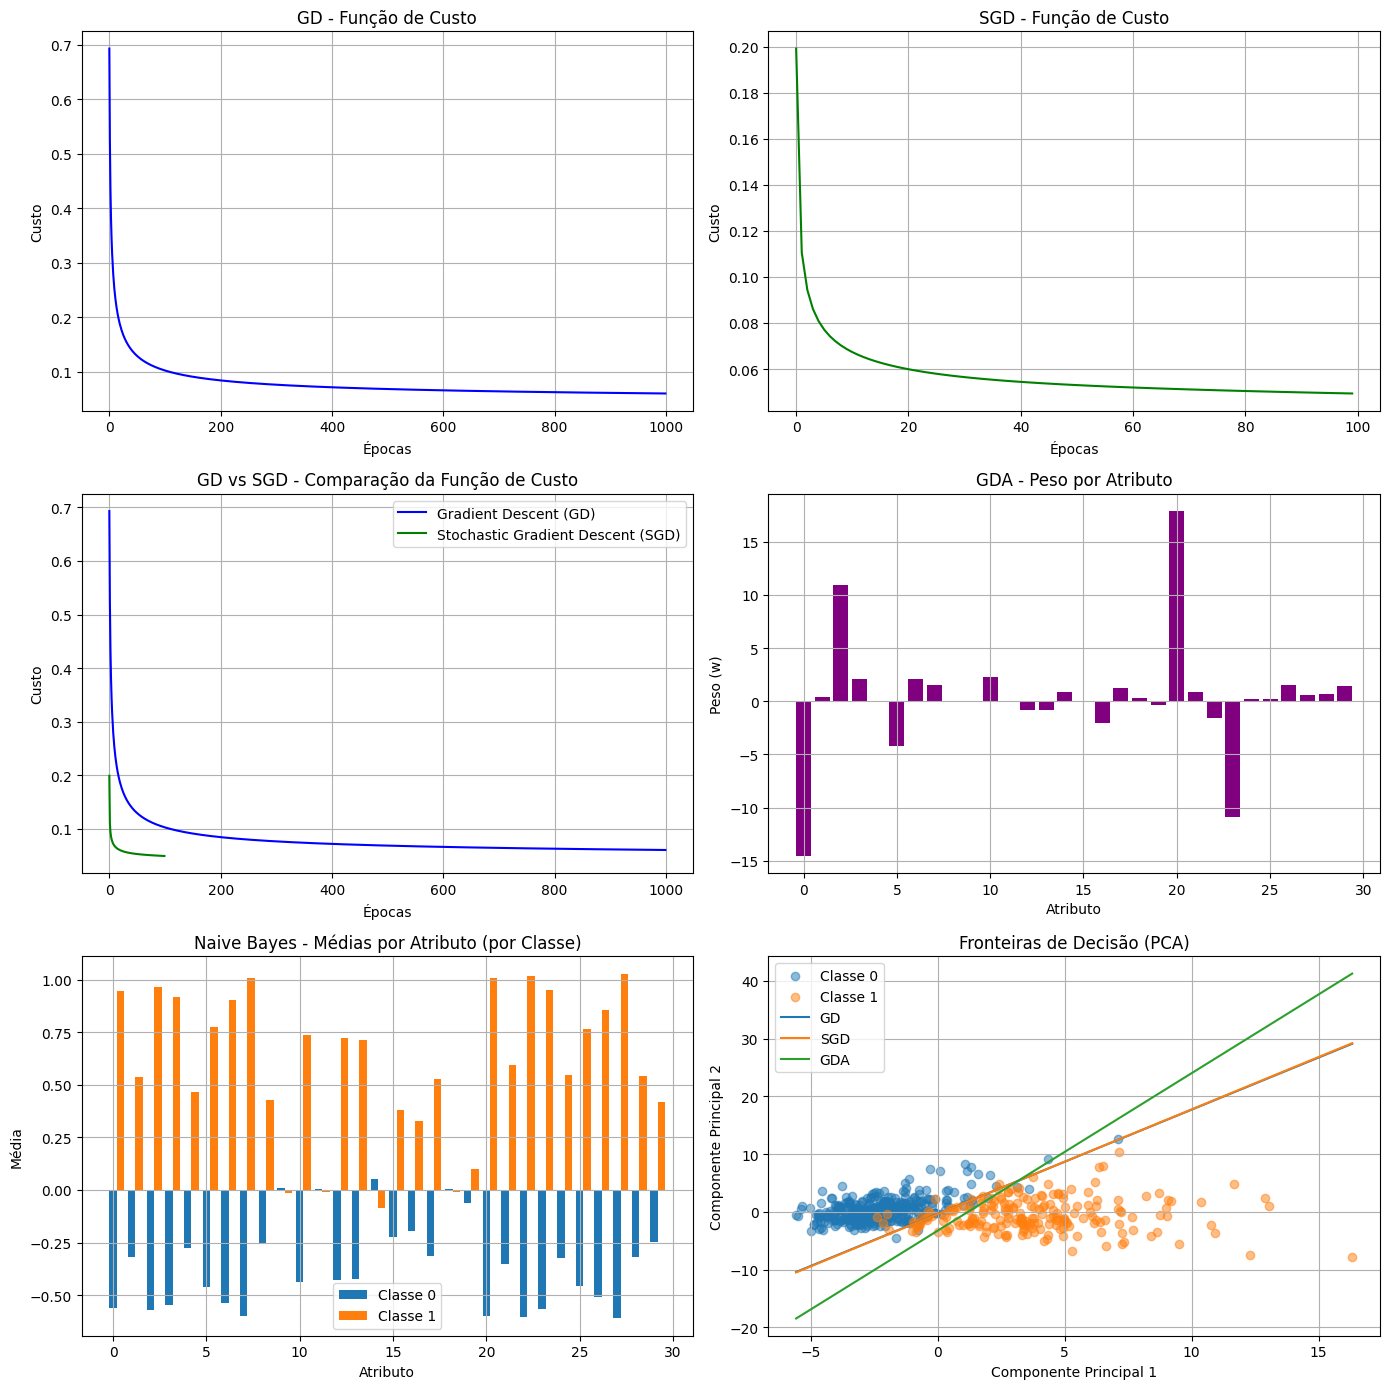

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Gráfico da função de custo

# Treina o modelo completo e plota a curva de aprendizado (perda vs. época).
# Aqui não preciso de w e b agora, apenas a lista de losses.

# Plota curva de custo do GD
_, _, losses = train_logistic_regression(X, y)

# Plota curva de custo do SGD
_, _, losses_sgd = train_logistic_regression_sgd(X, y)

# Treina GDA (adiciona esta linha aqui)
w_gda, _ = train_gda(X, y)

# Treina Naive Bayes
priors, means, stds = train_gaussian_naive_bayes(X, y)

# Extrai médias por atributo para cada classe
means_class_0 = means[0.0] # médias da classe 0
means_class_1 = means[1.0] # médias da classe 1

# Reduz os dados para 2 dimensões usando PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Treina os modelos nos dados reduzidos
w_gd, b_gd, _ = train_logistic_regression(X_reduced, y)
w_sgd, b_sgd, _ = train_logistic_regression_sgd(X_reduced, y)
w_gda_pca, b_gda = train_gda(X_reduced, y)

# Cria uma figura com 3 linhas e 2 colunas
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Gráfico 1: GD
axs[0, 0].plot(losses, color='blue')
axs[0, 0].set_title("GD - Função de Custo")
axs[0, 0].set_xlabel("Épocas")
axs[0, 0].set_ylabel("Custo")
axs[0, 0].grid(True)

# Gráfico 2: SGD
axs[0, 1].plot(losses_sgd, color='green')
axs[0, 1].set_title("SGD - Função de Custo")
axs[0, 1].set_xlabel("Épocas")
axs[0, 1].set_ylabel("Custo")
axs[0, 1].grid(True)

# Gráfico 3: Comparação Curva de Aprendizado
axs[1, 0].plot(losses, label="Gradient Descent (GD)", color='blue')
axs[1, 0].plot(losses_sgd, label="Stochastic Gradient Descent (SGD)", color='green')
axs[1, 0].set_title("GD vs SGD - Comparação da Função de Custo")
axs[1, 0].set_xlabel("Épocas")
axs[1, 0].set_ylabel("Custo")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Gráfico 4: GDA - Magnitude dos pesos (w)
axs[1, 1].bar(range(len(w_gda)), w_gda, color='purple')
axs[1, 1].set_title("GDA - Peso por Atributo")
axs[1, 1].set_xlabel("Atributo")
axs[1, 1].set_ylabel("Peso (w)")
axs[1, 1].grid(True)

# Gráfico 5: Naive Bayes - Médias dos atributos por classe
x_labels = range(len(means_class_0))
axs[2, 0].bar(x_labels, means_class_0, width=0.4, label="Classe 0", align="center")
axs[2, 0].bar([x + 0.4 for x in x_labels], means_class_1, width=0.4, label="Classe 1", align="center")
axs[2, 0].set_title("Naive Bayes - Médias por Atributo (por Classe)")
axs[2, 0].set_xlabel("Atributo")
axs[2, 0].set_ylabel("Média")
axs[2, 0].legend()
axs[2, 0].grid(True)

# Gráfico 6: PCA + Fronteiras de Decisão
def plot_decision_boundary(ax, w, b, label):
    x_vals = np.array([X_reduced[:, 0].min(), X_reduced[:, 0].max()])
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, label=label)

axs[2, 1].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label='Classe 0', alpha=0.5)
axs[2, 1].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label='Classe 1', alpha=0.5)
plot_decision_boundary(axs[2, 1], w_gd, b_gd, 'GD')
plot_decision_boundary(axs[2, 1], w_sgd, b_sgd, 'SGD')
plot_decision_boundary(axs[2, 1], w_gda_pca, b_gda, 'GDA')
axs[2, 1].set_title("Fronteiras de Decisão (PCA)")
axs[2, 1].set_xlabel("Componente Principal 1")
axs[2, 1].set_ylabel("Componente Principal 2")
axs[2, 1].legend()
axs[2, 1].grid(True)


# Ajusta o layout para não sobrepor textos
plt.tight_layout()
plt.show()


# Conclusão  - Questão 1

Nesta questão, testei quatro algoritmos de aprendizado supervisionado para classificação binária: Gradient Descent (GD), Stochastic Gradient Descent (SGD), Gaussian Discriminant Analysis (GDA) e Naive Bayes Gaussiano.

Os resultados obtidos permitiram analisar e comparar o desempenho de cada modelo sob diferentes perspectivas:

- O GD e o SGD apresentaram diferenças esperadas. O GD teve uma curva de custo mais suave, enquanto o SGD oscilou mais, mas foi mais rápido. Isso mostra como o SGD pode ser útil quando temos conjuntos de dados maiores.

- O modelo GDA funcionou bem, com pesos coerentes para os atributos. A visualização da fronteira de decisão (usando PCA) ajudou a entender como o modelo separa as duas classes, mesmo com a redução da dimensionalidade.

- No caso do Naive Bayes, apesar de ele considerar que os atributos são independentes (o que nem sempre é verdade), ele também teve um bom desempenho. O gráfico de médias por atributo para cada classe mostrou que existem diferenças visíveis entre as classes, o que favoreceu o modelo.

No geral, consegui implementar e analisar os modelos com sucesso, observando tanto o comportamento matemático (como a curva de custo) quanto as decisões tomadas pelos modelos de forma visual. Isso me ajudou a entender melhor como cada algoritmo funciona na prática.

## Questão 2

### Considere o conjunto de dados disponível em vehicle.csv organizado em 19 colunas, sendo as 18 primeiras colunas os atributos e a última coluna a saída. Os 18 atributos caracterizam a silhueta de veículos, extraídos pelo método HIPS (Hierarchical Image Processing System). A tarefa consiste em classificar o veículo em 4 classes (bus, opel, saab, e van). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/search?type=data&sort=runs&id=54.

a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

- Regressão softmax (treinado com GD ou SGD);
- Análise do discriminante Gaussiano;
- Naive Bayes Gaussiano;

b) Para cada modelo criado, reporte valor médio e desvio padrão da acurácia global e da acurácia por classe.

In [52]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict
from scipy.stats import norm

# 1. Carregando os dados
data = np.genfromtxt('vehicle.csv', delimiter=',')

# Separar atributos (X) e rótulos (y)
X = data[:, :-1]  # colunas 0 até 17
y = data[:, -1]   # última coluna

print(f'Shape dos dados: {X.shape}')
print(f'Classes únicas: {np.unique(y)}')

# 2. Função de divisão k-fold
# Embaralha os dados e divide em k partes (folds) para validação cruzada.
# Em cada iteração, uma parte é usada como teste, o resto como treino.
def k_fold_split(X, y, k=10, seed=42):

    np.random.seed(seed) # Define a semente do gerador de números aleatórios.
    indices = np.arange(len(X)) # Cria um array com os índices de 0 até len(X)-1
    np.random.shuffle(indices) # Embaralha esses índices de forma aleatória.

    # Reorganiza X e y com base nos índices embaralhados.
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # Calcula o tamanho de cada fold.
    fold_size = len(X) // k

    # Inicializa uma lista para armazenar cada divisão treino/teste (um total de k tuplas).
    folds = []

    # Para cada fold i
    for i in range(k):

        # Define o índice de início e fim do subconjunto de teste.
        start = i * fold_size
        end = (i + 1) * fold_size if i != k - 1 else len(X)

        # Extrai o conjunto de teste do intervalo [start:end].
        X_test = X_shuffled[start:end]
        y_test = y_shuffled[start:end]

        # Concatena as partes antes e depois do intervalo [start:end] para formar o conjunto de treino.
        X_train = np.concatenate((X_shuffled[:start], X_shuffled[end:]), axis=0)
        y_train = np.concatenate((y_shuffled[:start], y_shuffled[end:]), axis=0)

        # Armazena a tupla contendo os dados de treino e teste para esse fold.
        folds.append((X_train, y_train, X_test, y_test))

    # Ao final, retorna uma lista com k tuplas.
    return folds

# 3. Função softmax
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # estabilidade numérica evitando overflow
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# 4. Função para codificar classes em one-hot (ex: classe 0 => [1, 0])
def one_hot(y, num_classes):
    # Cria uma matriz de zeros com len(y) linhas (uma para cada amostra) e num_classes colunas.
    # Isso será preenchido com 1s em posições específicas para representar a classe de cada amostra.
    one_hot_encoded = np.zeros((len(y), num_classes))

    # Usa y.astype(int) para garantir que os valores estejam no formato inteiro
    for i, val in enumerate(y.astype(int)):
        # Para cada rótulo: Marca 1 na posição da classe correspondente.
        one_hot_encoded[i, int(val)] = 1
    # Retorna a matriz codificada
    return one_hot_encoded

# 5. Inicializar pesos com zeros (ou pequenos valores aleatórios)
def initialize_weights(n_features, n_classes):
    return np.zeros((n_features, n_classes))

# 6. Função de custo (cross-entropy loss)
def compute_loss(y_true, y_pred):
    eps = 1e-15  # para evitar log(0)

    # Garante que todos os valores de y_pred estejam entre eps e 1 - eps.
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # Calcula o logaritmo das probabilidades previstas multiplicando elemento a elemento.
    # Depois soma os valores para cada linha (cada amostra) e faz a média da perda entre todas as amostras.
    loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    # Retorna a perda média (um único número).
    return loss

# 7. Gradiente descendente para para treinar e retornar pesos + histórico de loss
def train_softmax_regression(X, y, learning_rate=0.1, epochs=500):

    # Extrai quantas amostras (n_samples) e quantas características (n_features) há nos dados de entrada X.
    n_samples, n_features = X.shape

    # Conta quantas classes diferentes existem nos rótulos y.
    n_classes = len(np.unique(y))

    # Aplica one-hot encoding nos rótulos.
    y_encoded = one_hot(y, n_classes)

    # Inicializa a matriz de pesos do modelo.
    weights = initialize_weights(n_features, n_classes)

    historico_loss = []

    for epoch in range(epochs):

        # Calcula o score bruto (logits)
        scores = X @ weights

        # Aplica a função softmax aos scores para obter probabilidades normalizadas de cada classe.
        probs = softmax(scores)

        # Calcula o gradiente do erro com relação aos pesos (derivada da função de perda).
        gradient = X.T @ (probs - y_encoded) / n_samples

        # Atualiza os pesos do modelo subtraindo o gradiente multiplicado pela taxa de aprendizado.
        weights -= learning_rate * gradient


        # A cada 100 iterações (ou na última), calcula o erro atual (loss) e imprime no terminal para acompanhar o treinamento.
        if epoch % 100 == 0 or epoch == epochs - 1:
            loss = compute_loss(y_encoded, probs)
            print(f"Época {epoch}, Loss: {loss:.4f}")

        historico_loss.append(loss)

    # Retorna a matriz final de pesos treinados.
    return weights, historico_loss

# 8. Função de predição
# Usa os pesos treinados para prever as classes mais prováveis com argmax.
def predict(X, weights):
    probs = softmax(X @ weights)
    return np.argmax(probs, axis=1)

# 9. Acurácia
# Percentual de acertos entre as previsões e os valores reais.
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# 10. Filtrar classes (para binarizar)
# Seleciona apenas duas classes (ex: classe 0 e classe 1).
# Reatribui classe1 → 0, classe2 → 1.
def filtrar_classes(X, y, classe1, classe2):
    filtro = (y == classe1) | (y == classe2)
    X_filtrado = X[filtro]
    y_filtrado = y[filtro]

    # reindexar classes para 0 e 1
    y_binario = np.where(y_filtrado == classe1, 0, 1)

    return X_filtrado, y_binario

# 11. Validação cruzada com Regressão Softmax
def cross_val_softmax(X, y, k=10, learning_rate=0.1, epochs=500):

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    acuracias_por_fold = {}
    historico_loss_por_fold = {}

    for fold_id, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Treina e obtém pesos e histórico de perda
        W, historico_loss = train_softmax_regression(X_train, y_train, learning_rate, epochs)


        # Avaliação
        y_pred = predict(X_test, W)
        acc = accuracy(y_test, y_pred)

        acuracias_por_fold[fold_id] = acc
        historico_loss_por_fold[fold_id] = historico_loss

    return acuracias_por_fold, historico_loss_por_fold

# 12. treinar gda
def train_gda(X, y):
    classes = np.unique(y)
    n_classes = len(classes)
    n_features = X.shape[1]
    means = {}
    priors = {}
    cov = np.zeros((n_features, n_features))

    # Estima média e prior para cada classe
    for cls in classes:
        X_cls = X[y == cls]
        means[cls] = np.mean(X_cls, axis=0)
        priors[cls] = X_cls.shape[0] / X.shape[0]
        cov += (X_cls - means[cls]).T @ (X_cls - means[cls])

    cov /= X.shape[0]  # Covariância compartilhada

    return means, priors, cov

# 13. Função de predição do gda
def predict_gda(X, means, priors, cov):
    inv_cov = np.linalg.inv(cov)
    scores = []

    for cls in means:
        mu = means[cls]
        prior = priors[cls]

        # Equação do discriminante linear:
        # g_k(x) = x.T @ inv_cov @ mu_k - 0.5 * mu_k.T @ inv_cov @ mu_k + log(prior_k)
        a = X @ inv_cov @ mu
        b = -0.5 * mu.T @ inv_cov @ mu
        c = np.log(prior)
        g = a + b + c
        scores.append(g)

    scores = np.stack(scores, axis=1)
    return np.argmax(scores, axis=1)

# 14. Função cross_val_gda (Análise Discriminante Gaussiana)
def cross_val_gda(X, y, k=10):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acuracias_por_fold = {}

    for fold_id, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        means, priors, cov = train_gda(X_train, y_train)
        y_pred = predict_gda(X_test, means, priors, cov)
        acc = accuracy(y_test, y_pred)

        acuracias_por_fold[fold_id] = acc

    return acuracias_por_fold

acuracias_gda = cross_val_gda(X, y)
print("\nAcurácias GDA por fold:")
for fold_id, acc in acuracias_gda.items():
    print(f"  Fold {fold_id}: {acc:.4f}")

print(f"\nMédia das acurácias: {np.mean(list(acuracias_gda.values())):.4f}")


class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-9  # Evita divisão por zero
            self.prior[c] = X_c.shape[0] / X.shape[0]

    def _gaussian_density(self, x, mean, var):
        # PDF da normal univariada
        return np.exp(-0.5 * ((x - mean) ** 2) / var) / np.sqrt(2 * np.pi * var)

    def predict(self, X):
        preds = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.prior[c])
                likelihood = np.sum(np.log(self._gaussian_density(x, self.mean[c], self.var[c])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            preds.append(self.classes[np.argmax(posteriors)])
        return np.array(preds)

def cross_val_naive_bayes(X, y, k=10):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acuracias = []
    resultados_folds = {}

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        nb = GaussianNaiveBayes()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        acc = np.mean(y_pred == y_test)

        acuracias.append(acc)
        resultados_folds[i] = acc
        print(f"[Fold {i+1}] Acurácia: {acc:.4f}")

    media = np.mean(acuracias)
    print(f"\nAcurácia média (Naive Bayes): {media:.4f}")
    return resultados_folds

resultados_nb = cross_val_naive_bayes(X, y, k=10)


Shape dos dados: (846, 18)
Classes únicas: [0. 1. 2. 3.]

Acurácias GDA por fold:
  Fold 0: 0.8118
  Fold 1: 0.7647
  Fold 2: 0.7294
  Fold 3: 0.8000
  Fold 4: 0.7647
  Fold 5: 0.7647
  Fold 6: 0.7976
  Fold 7: 0.7738
  Fold 8: 0.7857
  Fold 9: 0.8214

Média das acurácias: 0.7814
[Fold 1] Acurácia: 0.3765
[Fold 2] Acurácia: 0.5294
[Fold 3] Acurácia: 0.4941
[Fold 4] Acurácia: 0.4706
[Fold 5] Acurácia: 0.3765
[Fold 6] Acurácia: 0.4588
[Fold 7] Acurácia: 0.4762
[Fold 8] Acurácia: 0.4286
[Fold 9] Acurácia: 0.4405
[Fold 10] Acurácia: 0.4524

Acurácia média (Naive Bayes): 0.4504


In [53]:
# 12. Execução: rodando classificação binária

import pandas as pd
from itertools import combinations

# Obter as classes únicas
classes_unicas = np.unique(y).astype(int)

# Gerar todos os pares possíveis de classes
pares = list(combinations(classes_unicas, 2))

# Guardar resultados
resultados_tabela = []
resultados_loss = {}
resultados_acuracia_folds = {}

for classe1, classe2 in pares:

    # Filtra apenas as amostras dessas duas classes
    X_bin, y_bin = filtrar_classes(X, y, classe1, classe2)

    # Normaliza os dados
    X_bin = (X_bin - np.mean(X_bin, axis=0)) / np.std(X_bin, axis=0)

    # Treina e avalia o modelo
    acuracias_por_fold, historico_loss_por_fold = cross_val_softmax(X_bin, y_bin, k=10, learning_rate=0.1, epochs=500)

    # Salva os resultados para os graficos
    resultados_loss[(classe1, classe2)] = historico_loss_por_fold
    resultados_acuracia_folds[(classe1, classe2)] = list(acuracias_por_fold.values())

    # Salva o resultado para a tabela
    media = np.mean(list(acuracias_por_fold.values()))
    desvio = np.std(list(acuracias_por_fold.values()))
    resultados_tabela.append(((classe1, classe2), media, desvio))

    # Mostrar em tabela o resultado do par atual
    linha = pd.DataFrame([((classe1, classe2), media, desvio)], columns=["Par de Classes", "Acurácia Média", "Desvio Padrão"])
    linha["Acurácia Média"] = linha["Acurácia Média"].apply(lambda x: f"{x:.4f}")
    linha["Desvio Padrão"] = linha["Desvio Padrão"].apply(lambda x: f"{x:.4f}")
    print("\n=== Resultado Parcial ===")
    print(linha.to_string(index=False))

# Exibir resumo final

# Criar DataFrame com os resultados
df_resultados = pd.DataFrame(resultados_tabela, columns=["Par de Classes", "Acurácia Média", "Desvio Padrão"])

# Formatar os valores com 4 casas decimais
df_resultados["Acurácia Média"] = df_resultados["Acurácia Média"].apply(lambda x: f"{x:.4f}")
df_resultados["Desvio Padrão"] = df_resultados["Desvio Padrão"].apply(lambda x: f"{x:.4f}")

# Exibir a tabela
print("\n=== Tabela de Resultados (Pares de Classes) ===")
print(df_resultados.to_string(index=False))

Época 0, Loss: 0.6931
Época 100, Loss: 0.2893
Época 200, Loss: 0.2395
Época 300, Loss: 0.2149
Época 400, Loss: 0.1989
Época 499, Loss: 0.1870
Época 0, Loss: 0.6931
Época 100, Loss: 0.2922
Época 200, Loss: 0.2429
Época 300, Loss: 0.2187
Época 400, Loss: 0.2031
Época 499, Loss: 0.1918
Época 0, Loss: 0.6931
Época 100, Loss: 0.2920
Época 200, Loss: 0.2417
Época 300, Loss: 0.2168
Época 400, Loss: 0.2006
Época 499, Loss: 0.1889
Época 0, Loss: 0.6931
Época 100, Loss: 0.2736
Época 200, Loss: 0.2239
Época 300, Loss: 0.2000
Época 400, Loss: 0.1848
Época 499, Loss: 0.1739
Época 0, Loss: 0.6931
Época 100, Loss: 0.2843
Época 200, Loss: 0.2355
Época 300, Loss: 0.2117
Época 400, Loss: 0.1963
Época 499, Loss: 0.1853
Época 0, Loss: 0.6931
Época 100, Loss: 0.2581
Época 200, Loss: 0.2059
Época 300, Loss: 0.1810
Época 400, Loss: 0.1653
Época 499, Loss: 0.1542
Época 0, Loss: 0.6931
Época 100, Loss: 0.2910
Época 200, Loss: 0.2415
Época 300, Loss: 0.2171
Época 400, Loss: 0.2012
Época 499, Loss: 0.1895
Época 

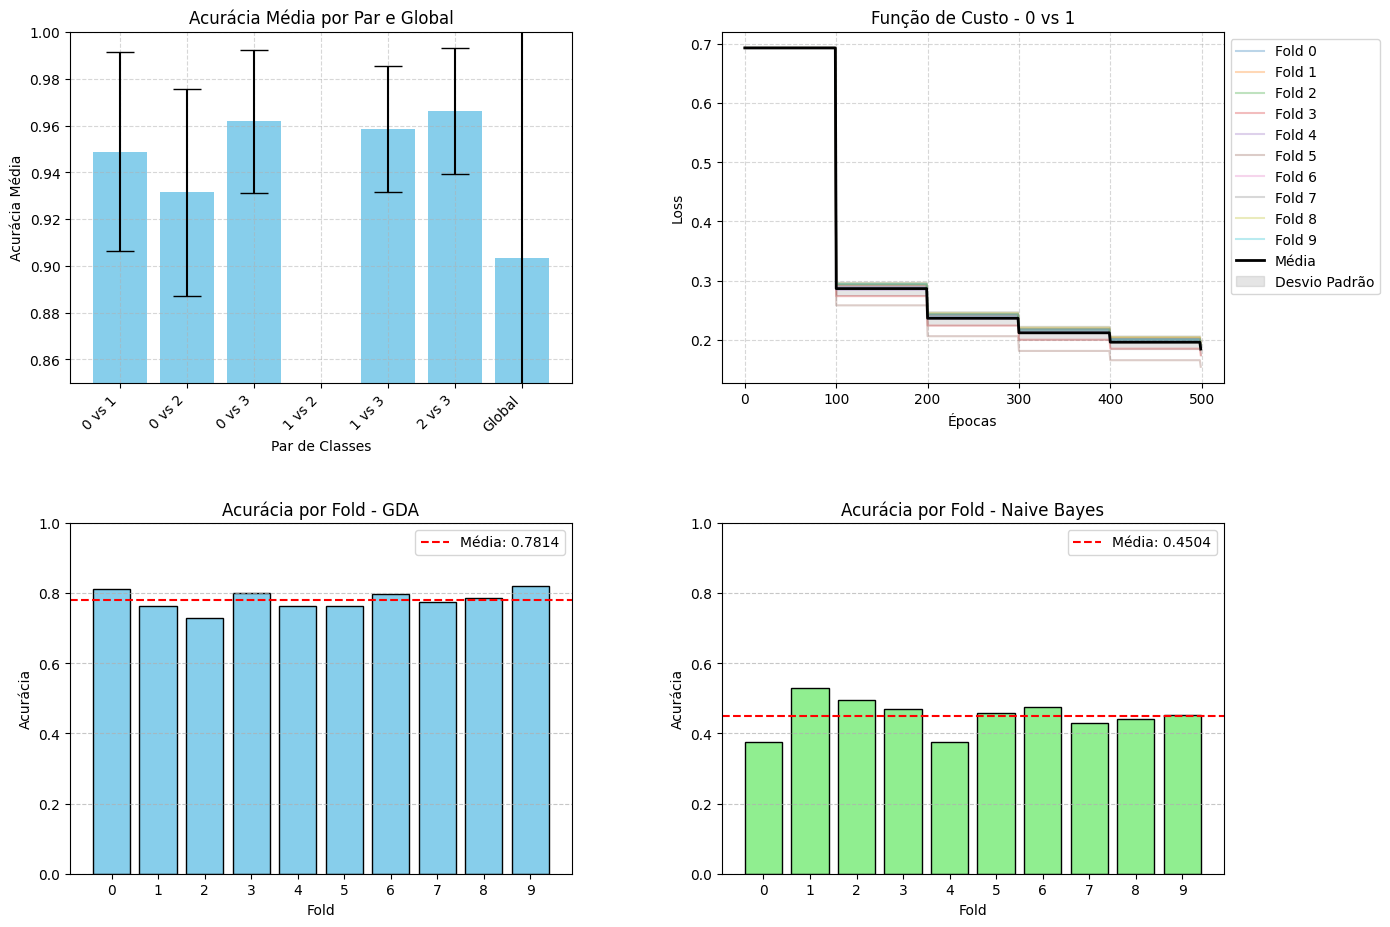

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular acurácia global (considerando todos os pares e todos os folds)
todas_acuracias = [ac for acuracias in resultados_acuracia_folds.values() for ac in acuracias]
acuracia_global_media = np.mean(todas_acuracias)
acuracia_global_std = np.std(todas_acuracias)

# Preparar dados para gráfico de barras
pares_classes_plot = list(resultados_acuracia_folds.keys())
acuracias_medias = [np.mean(resultados_acuracia_folds[par]) for par in pares_classes_plot]
desvios_padroes = [np.std(resultados_acuracia_folds[par]) for par in pares_classes_plot]

labels = [f'{par[0]} vs {par[1]}' for par in pares_classes_plot]
labels.append('Global')
acuracias_medias.append(acuracia_global_media)
desvios_padroes.append(acuracia_global_std)

# Criar grade de 2 linhas x 2 colunas
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# === Gráfico 1: Acurácia Média por Par e Global ===
ax1 = axs[0, 0]
ax1.bar(labels, acuracias_medias, yerr=desvios_padroes, capsize=10, color='skyblue')
ax1.set_ylim(0.85, 1.0)
ax1.set_xlabel('Par de Classes')
ax1.set_ylabel('Acurácia Média')
ax1.set_title('Acurácia Média por Par e Global')
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)  # Alinha os labels à direita e rotaciona
ax1.grid(True, linestyle='--', alpha=0.5)

# === Gráfico 2: Função de Custo (Loss) ===
ax2 = axs[0, 1]
if resultados_loss:
    primeiro_par = list(resultados_loss.keys())[0]
    loss_por_fold = resultados_loss[primeiro_par]

    epocas = list(range(len(next(iter(loss_por_fold.values())))))
    todas_losses = np.array([losses for losses in loss_por_fold.values()])
    loss_media = np.mean(todas_losses, axis=0)
    loss_std = np.std(todas_losses, axis=0)

    for fold_id, losses in loss_por_fold.items():
        ax2.plot(epocas, losses, alpha=0.3, label=f'Fold {fold_id}')

    ax2.plot(epocas, loss_media, color='black', linewidth=2, label='Média')
    ax2.fill_between(epocas, loss_media - loss_std, loss_media + loss_std,
                     color='gray', alpha=0.2, label='Desvio Padrão')

    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'Função de Custo - {primeiro_par[0]} vs {primeiro_par[1]}')
    # Legenda fora do gráfico
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.grid(True, linestyle='--', alpha=0.5)
else:
    ax2.set_title('Nenhum dado de Loss para plotar')

# === Gráfico 3: Acurácia por Fold (GDA Multiclasse) ===
ax3 = axs[1, 0]
folds = list(acuracias_gda.keys())
acuracias = list(acuracias_gda.values())
ax3.bar(folds, acuracias, color='skyblue', edgecolor='black')
ax3.set_ylim(0, 1)
ax3.set_xlabel('Fold')
ax3.set_ylabel('Acurácia')
ax3.set_title('Acurácia por Fold - GDA')
ax3.set_xticks(folds)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
media = np.mean(acuracias)
ax3.axhline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
ax3.legend()

# === Gráfico 4: Acurácia por Fold (Naive Bayes) ===
ax4 = axs[1, 1]
folds_nb = list(resultados_nb.keys())
acuracias_nb = list(resultados_nb.values())
ax4.bar(folds_nb, acuracias_nb, color='lightgreen', edgecolor='black')
ax4.set_ylim(0, 1)
ax4.set_xlabel('Fold')
ax4.set_ylabel('Acurácia')
ax4.set_title('Acurácia por Fold - Naive Bayes')
ax4.set_xticks(folds_nb)
ax4.grid(axis='y', linestyle='--', alpha=0.7)
media_nb = np.mean(acuracias_nb)
ax4.axhline(media_nb, color='red', linestyle='--', label=f'Média: {media_nb:.4f}')
ax4.legend()

# Ajustar layout para evitar sobreposição
fig.tight_layout()
fig.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

plt.show()


## Conclusão da Questão 2

Nesta questão, implementei a validação cruzada k-fold para três métodos de classificação: Regressão Softmax, Análise Discriminante Gaussiana (GDA) e Naive Bayes Gaussiano. O objetivo principal foi avaliar seu desempenho através da acurácia média em múltiplas divisões dos dados.

Os resultados mostraram as acurácias por fold para cada método, permitindo a comparação do desempenho. A Regressão Softmax, por ser um modelo discriminativo otimizado diretamente para classificação, apresentou uma performance consistente. Já a GDA e o Naive Bayes, que são métodos generativos, forneceram alternativas baseadas em diferentes pressupostos sobre a distribuição dos dados.

Com essa implementação prática, pude compreender melhor as diferenças conceituais e operacionais entre os modelos, bem como a importância da validação cruzada para avaliar a robustez e generalização dos classificadores. A experiência destacou também aspectos técnicos, como a necessidade de normalização numérica para estabilidade computacional na softmax e cuidados para evitar divisões por zero no Naive Bayes.

Em resumo, esta questão foi fundamental para consolidar conceitos teóricos na prática e aprimorar habilidades em manipulação de dados, implementação de algoritmos de aprendizado e avaliação de modelos, reforçando a importância da experimentação e análise crítica dos resultados.